In [4]:
import gdown

link = 'https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8'
# Download the file
gdown.download(link, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=4ee3a981-3ead-49db-8082-c2ee6e8f38d2
To: d:\C\vscode\AIO2024-EXERCISES\Module 5\Week 3\FER-2013.zip
100%|██████████| 63.3M/63.3M [00:02<00:00, 22.8MB/s]


'FER-2013.zip'

In [7]:
# Unzip the file
import zipfile
with zipfile.ZipFile('FER-2013.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [8]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
train_dir = './data/train'
test_dir = './data/test'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

In [13]:
test_img_path = './train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(img_height)
print(img_width)

class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split = 'train', train_ratio = 0.8):
        self.resize = Resize((img_height, img_width))
        self.img_dir = img_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size = self.train_ratio,
                random_state = random_state,
                stratify = self.img_labels
            )
        if split == 'train':
            self.img_paths, self.img_labels = zip(*train_data)
        elif split == 'val':
            self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths, img_labels = [], []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, cls = self.img_paths[idx], self.img_labels[idx]
        img = self.resize(read_image(img_path)).type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label

128
128


In [14]:
batch_size = 256

train_dataset = ImageDataset(train_dir,True, label2idx, split = 'train')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = ImageDataset(train_dir,True, label2idx, split = 'val')
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

test_dataset = ImageDataset(test_dir,True, label2idx, split = 'test')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

c:\Users\quanb\.conda\envs\ruludit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


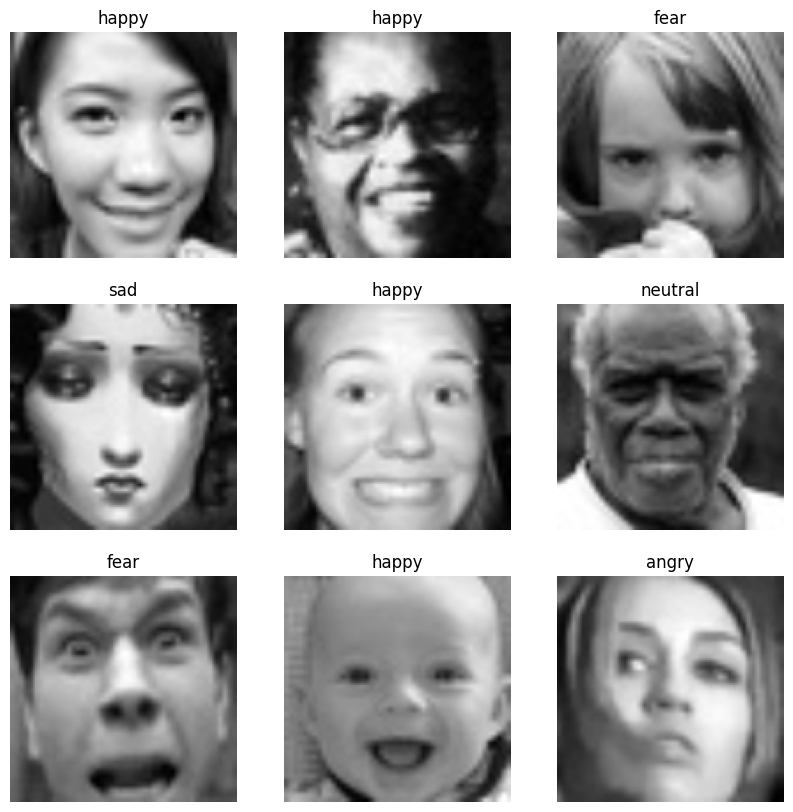

In [15]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap = 'gray')
    label = label_batch[i]
    plt.title(f"{idx2label[label.item()]}")
    plt.axis("off")


In [22]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims*4)
    self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
    self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)

input_dims = img_height * img_width
hidden_dims = 64
lr = 1e-2
output_dims = len(classes)

model = MLP(input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [23]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  return correct / len(y_true)

In [24]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_pred = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_pred.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_pred = torch.cat(train_pred)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_pred, train_target))

    model.eval()
    val_loss = 0.0
    val_target = []
    val_pred = []
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_pred.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_pred = torch.cat(val_pred)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_pred, val_target))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

c:\Users\quanb\.conda\envs\ruludit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/40, Train Loss: 1.9118, Val Loss: 1.8699
Epoch 2/40, Train Loss: 1.8343, Val Loss: 1.8155
Epoch 3/40, Train Loss: 1.7986, Val Loss: 1.7947
Epoch 4/40, Train Loss: 1.7813, Val Loss: 1.7813
Epoch 5/40, Train Loss: 1.7683, Val Loss: 1.7681
Epoch 6/40, Train Loss: 1.7547, Val Loss: 1.7539
Epoch 7/40, Train Loss: 1.7382, Val Loss: 1.7363
Epoch 8/40, Train Loss: 1.7185, Val Loss: 1.7135
Epoch 9/40, Train Loss: 1.6956, Val Loss: 1.6923
Epoch 10/40, Train Loss: 1.6739, Val Loss: 1.6756
Epoch 11/40, Train Loss: 1.6562, Val Loss: 1.6602
Epoch 12/40, Train Loss: 1.6409, Val Loss: 1.6501
Epoch 13/40, Train Loss: 1.6296, Val Loss: 1.6419
Epoch 14/40, Train Loss: 1.6192, Val Loss: 1.6352
Epoch 15/40, Train Loss: 1.6093, Val Loss: 1.6272
Epoch 16/40, Train Loss: 1.6002, Val Loss: 1.6223
Epoch 17/40, Train Loss: 1.5914, Val Loss: 1.6168
Epoch 18/40, Train Loss: 1.5836, Val Loss: 1.6117
Epoch 19/40, Train Loss: 1.5755, Val Loss: 1.6077
Epoch 20/40, Train Loss: 1.5674, Val Loss: 1.6014
Epoch 21/

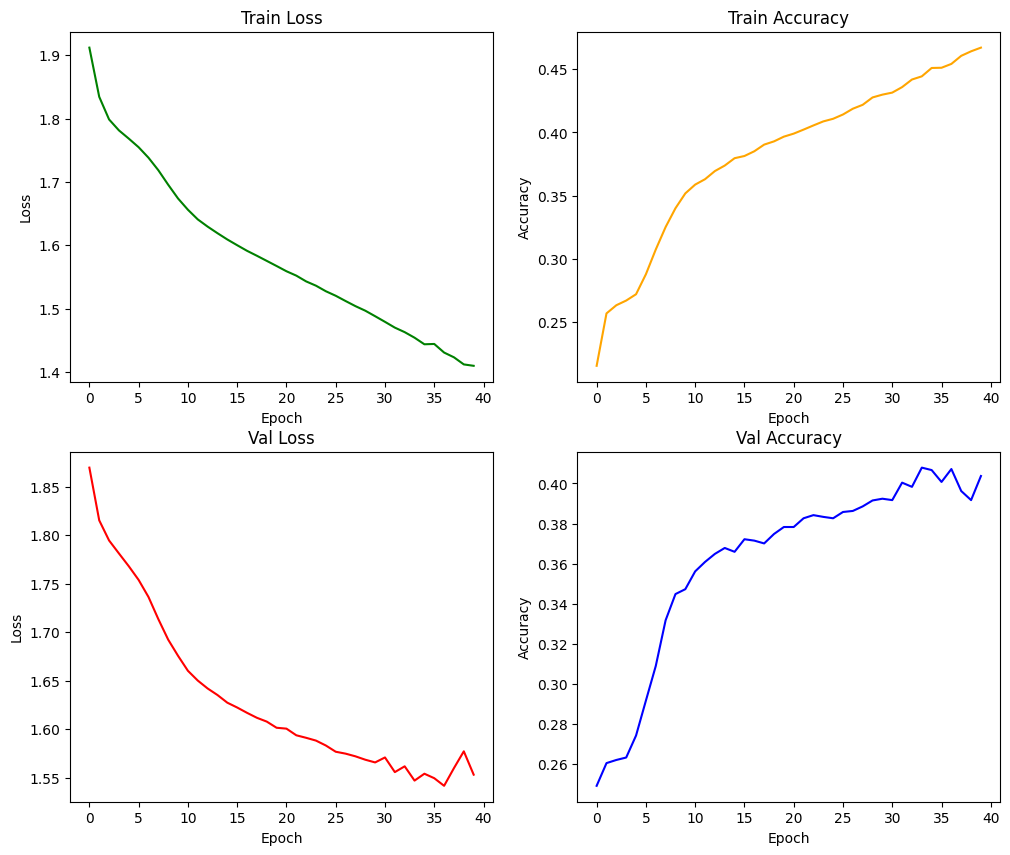

In [25]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(train_accs, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[0, 1].set_title('Train Accuracy')

ax[1, 0].plot(val_losses, color='red')
ax[1, 0].set(xlabel='Epoch', ylabel='Loss')
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_accs, color='blue')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Val Accuracy')

plt.show()

In [26]:
test_target = []
test_pred = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_pred.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_pred = torch.cat(test_pred)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_pred, test_target)
print(f'Test Accuracy: {test_acc:.4f}')

c:\Users\quanb\.conda\envs\ruludit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Accuracy: 0.4118
